# Statistical Analysis of Bay Area Bike Share Data - Station Status

# Station Balance at Top Commuter Stations
<ul>Top Commuter Stations
	<li><b>Station 70 :</b> San Francisco Caltrain (Townsend at 4th)</li>
	<li><b>Station 69 :</b> San Francisco Caltrain 2 (330 Townsend)</li>
	<li><b>Station 50 :</b> Harry Bridges Plaza (Ferry Building)</li>
	<li><b>Station 55 :</b> Temporary Transbay Terminal (Howard at Beale)</li>
	<li><b>Station 74 :</b> Steuart at Market</li>
</ul>

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from glob import glob

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 20
TICK_FONT_SIZE  = 15

In [3]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

In [4]:
pop_commuter_stations = [50, 55, 69, 70, 74]

# Load Data

## Trip Data

In [5]:
print('[%s] Loading Trip Data...' % datetime.datetime.now().time())

trips_df = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):
    
#     # prune chunks
#     chunk = chunk[(chunk.start_terminal.isin(pop_commuter_stations)) | (chunk.end_terminal.isin(pop_commuter_stations))].copy()
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

trips_df = pd.concat(chunks)
trips_df.user_type = trips_df.user_type.astype('category')

trips_df.drop_duplicates(inplace=True)
trips_df.sort_values('trip_id', inplace=True)
trips_df.reset_index(inplace=True, drop=True)

print('[%s] Complete!' % datetime.datetime.now().time())

[13:59:07.866838] Loading Trip Data...
		[13:59:08.818779] finished chunk 1 of 96
		[13:59:09.366966] finished chunk 10 of 96
		[13:59:10.157079] finished chunk 20 of 96
		[13:59:11.125106] finished chunk 30 of 96
		[13:59:11.788144] finished chunk 40 of 96
		[13:59:12.381832] finished chunk 50 of 96
		[13:59:12.950513] finished chunk 60 of 96
		[13:59:13.529807] finished chunk 70 of 96
		[13:59:14.087492] finished chunk 80 of 96
		[13:59:14.652117] finished chunk 90 of 96
		[13:59:14.965030] finished chunk 96 of 96
[13:59:17.151770] Complete!


In [6]:
trips = trips_df.copy()

In [7]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955557 entries, 0 to 955556
Data columns (total 12 columns):
trip_id               955557 non-null int64
duration              955557 non-null int64
start_date            955557 non-null datetime64[ns]
start_station_name    955557 non-null object
start_terminal        955557 non-null int64
end_date              955557 non-null datetime64[ns]
end_station_name      955557 non-null object
end_terminal          955557 non-null int64
bike_id               955557 non-null int64
user_type             955557 non-null category
user_zip              955557 non-null int64
duration_minutes      955557 non-null float64
dtypes: category(1), datetime64[ns](2), float64(1), int64(6), object(2)
memory usage: 81.1+ MB


# Station Balancing

In [8]:
trips.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000


In [9]:
station_start_trips = trips.groupby(['start_terminal', 'start_date']).count()['trip_id'].to_frame()
station_start_trips.reset_index(inplace=True)
station_start_trips.columns = ['start_terminal', 'start_date', 'start_trip_count']

station_end_trips = trips.groupby(['end_terminal', 'end_date']).count()['trip_id'].to_frame()
station_end_trips.reset_index(inplace=True)
station_end_trips.columns = ['end_terminal', 'end_date', 'end_trip_count']

In [10]:
A = station_start_trips#.head(3000)

In [11]:
B = station_end_trips#.head(3000)

In [12]:
epoch = pd.to_datetime([1], unit='D')[0]
print(type(epoch))

<class 'pandas._libs.tslib.Timestamp'>


In [13]:
station_balance = A.merge(B, left_on=['start_terminal', 'start_date'], right_on=['end_terminal', 'end_date'], how='outer')

station_balance['end_date'].fillna(epoch, inplace=True)
station_balance['start_date'].fillna(epoch, inplace=True)



station_balance.fillna(0, inplace=True)
station_balance

,start_terminal,start_date,start_trip_count,end_terminal,end_date,end_trip_count
0,2.0,2013-08-29 13:52:00,1.0,0.0,1970-01-02 00:00:00,0.0
1,2.0,2013-08-29 17:33:00,1.0,0.0,1970-01-02 00:00:00,0.0
2,2.0,2013-08-29 19:18:00,1.0,0.0,1970-01-02 00:00:00,0.0
3,2.0,2013-08-29 19:57:00,1.0,0.0,1970-01-02 00:00:00,0.0
4,2.0,2013-08-29 20:36:00,1.0,0.0,1970-01-02 00:00:00,0.0
5,2.0,2013-08-30 08:28:00,1.0,0.0,1970-01-02 00:00:00,0.0
6,2.0,2013-08-30 08:41:00,1.0,0.0,1970-01-02 00:00:00,0.0
7,2.0,2013-08-30 18:38:00,1.0,0.0,1970-01-02 00:00:00,0.0
8,2.0,2013-08-30 19:51:00,1.0,0.0,1970-01-02 00:00:00,0.0
9,2.0,2013-08-31 14:22:00,1.0,0.0,1970-01-02 00:00:00,0.0


In [14]:
station_balance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712996 entries, 0 to 1712995
Data columns (total 6 columns):
start_terminal      float64
start_date          datetime64[ns]
start_trip_count    float64
end_terminal        float64
end_date            datetime64[ns]
end_trip_count      float64
dtypes: datetime64[ns](2), float64(4)
memory usage: 91.5 MB


In [15]:
def merge_fix(start, end):

    if start > end:
        return start
    else:
        return end

In [16]:
station_balance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712996 entries, 0 to 1712995
Data columns (total 6 columns):
start_terminal      float64
start_date          datetime64[ns]
start_trip_count    float64
end_terminal        float64
end_date            datetime64[ns]
end_trip_count      float64
dtypes: datetime64[ns](2), float64(4)
memory usage: 91.5 MB


In [17]:
station_balance['time'] = station_balance.apply(lambda row: merge_fix(row['start_date'], row['end_date']), axis=1)
station_balance['terminal'] = station_balance.apply(lambda row: merge_fix(row['start_terminal'], row['end_terminal']), axis=1)

station_balance

,start_terminal,start_date,start_trip_count,end_terminal,end_date,end_trip_count,time,terminal
0,2.0,2013-08-29 13:52:00,1.0,0.0,1970-01-02 00:00:00,0.0,2013-08-29 13:52:00,2.0
1,2.0,2013-08-29 17:33:00,1.0,0.0,1970-01-02 00:00:00,0.0,2013-08-29 17:33:00,2.0
2,2.0,2013-08-29 19:18:00,1.0,0.0,1970-01-02 00:00:00,0.0,2013-08-29 19:18:00,2.0
3,2.0,2013-08-29 19:57:00,1.0,0.0,1970-01-02 00:00:00,0.0,2013-08-29 19:57:00,2.0
4,2.0,2013-08-29 20:36:00,1.0,0.0,1970-01-02 00:00:00,0.0,2013-08-29 20:36:00,2.0
5,2.0,2013-08-30 08:28:00,1.0,0.0,1970-01-02 00:00:00,0.0,2013-08-30 08:28:00,2.0
6,2.0,2013-08-30 08:41:00,1.0,0.0,1970-01-02 00:00:00,0.0,2013-08-30 08:41:00,2.0
7,2.0,2013-08-30 18:38:00,1.0,0.0,1970-01-02 00:00:00,0.0,2013-08-30 18:38:00,2.0
8,2.0,2013-08-30 19:51:00,1.0,0.0,1970-01-02 00:00:00,0.0,2013-08-30 19:51:00,2.0
9,2.0,2013-08-31 14:22:00,1.0,0.0,1970-01-02 00:00:00,0.0,2013-08-31 14:22:00,2.0


In [18]:
station_balance = station_balance[['time', 'terminal', 'start_trip_count', 'end_trip_count']].copy()

station_balance.sort_values(['terminal', 'time'], inplace=True)
station_balance.reset_index(inplace=True, drop=True)


In [19]:
station_balance['balance'] = station_balance.end_trip_count - station_balance.start_trip_count

In [20]:
station_balance.terminal = station_balance.terminal.astype('int')
station_balance.start_trip_count = station_balance.start_trip_count.astype('int')
station_balance.end_trip_count = station_balance.end_trip_count.astype('int')
station_balance.balance = station_balance.balance.astype('int')

In [21]:
print(station_balance.groupby('terminal').balance.cumsum().max())
print(station_balance.groupby('terminal').balance.cumsum().min())

19329
-10547


In [22]:
station_balance.head(3)

,time,terminal,start_trip_count,end_trip_count,balance
0,2013-08-29 13:10:00,2,0,1,1
1,2013-08-29 13:52:00,2,1,0,-1
2,2013-08-29 17:17:00,2,0,1,1


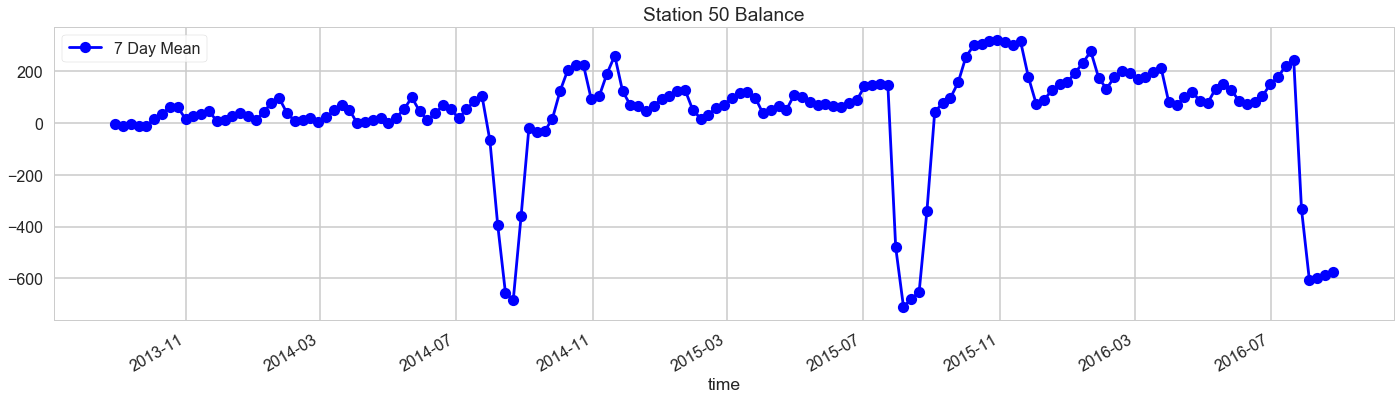

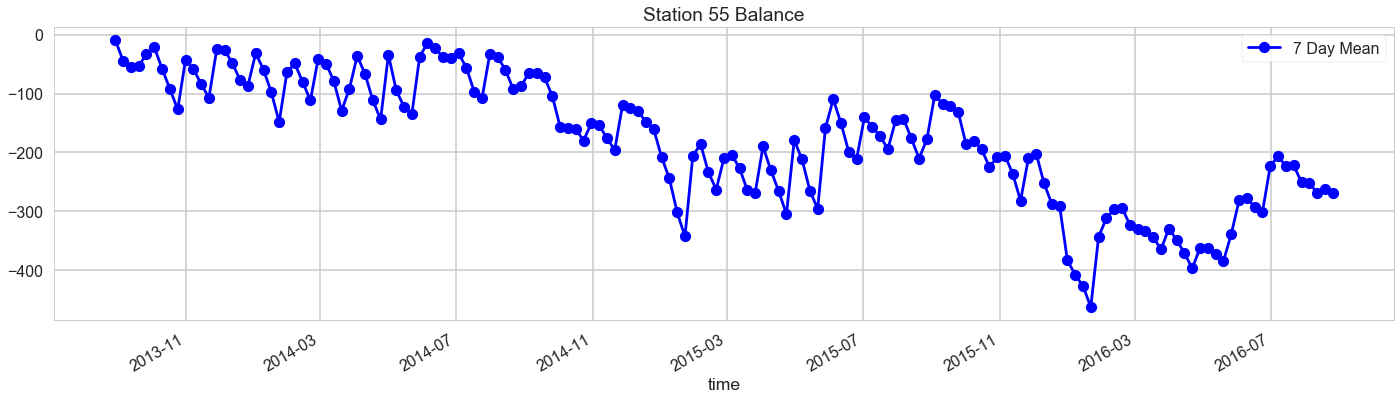

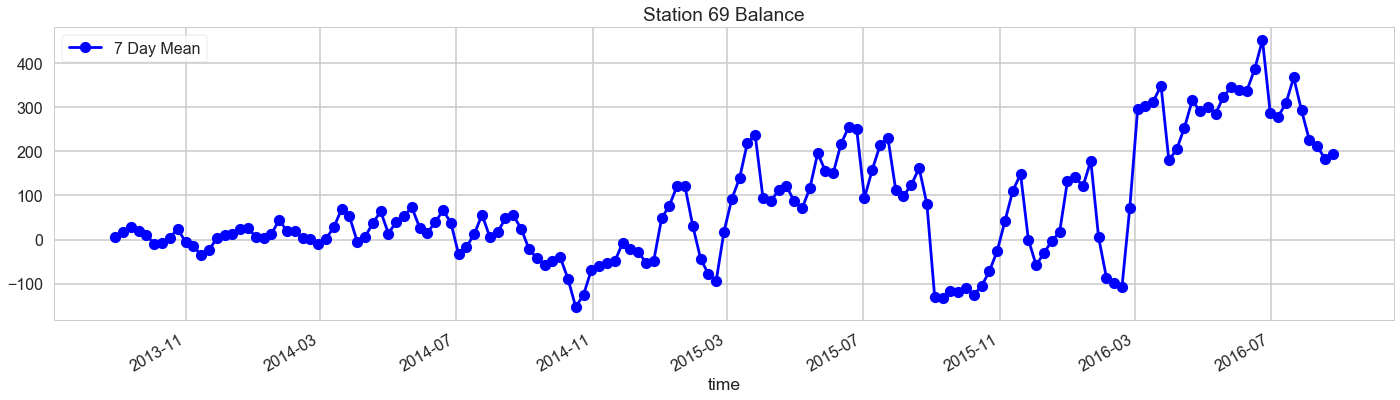

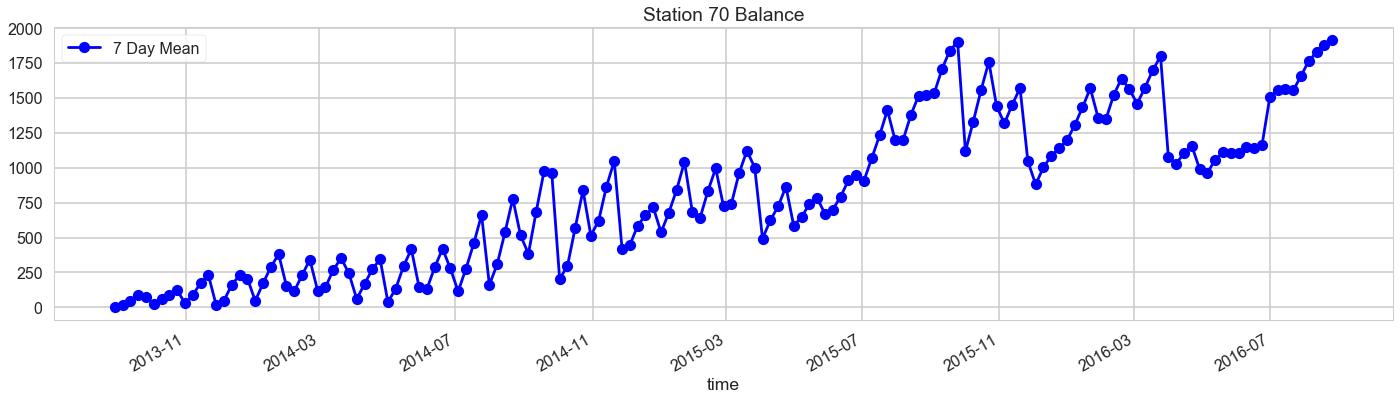

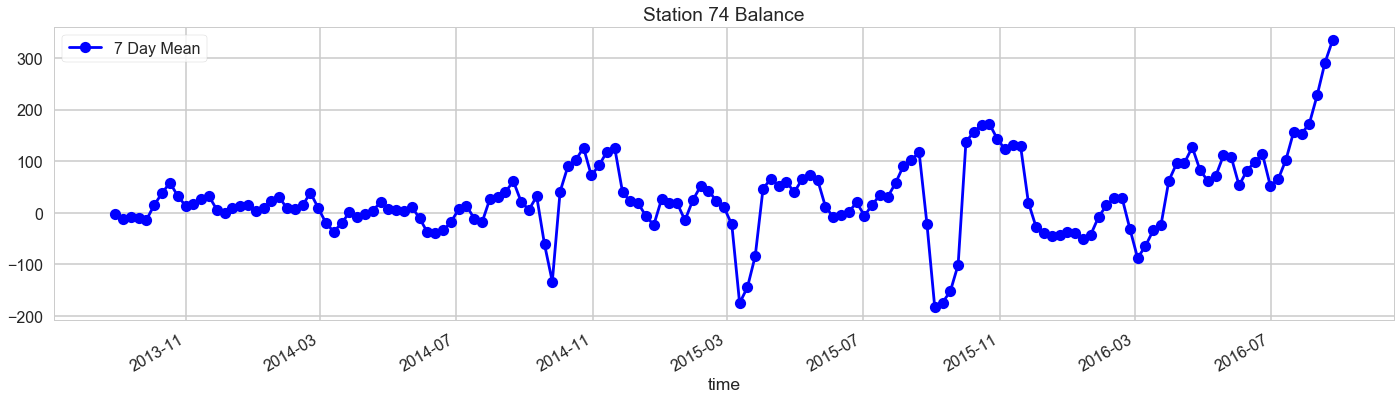

In [23]:
# for sid in sorted(station_balance.terminal.unique()):
for sid in sorted(pop_commuter_stations):
    
    data = station_balance[station_balance.terminal == sid].copy()

    data.set_index('time', inplace=True, drop=True)
    ax = data.groupby(data.index.month).balance.cumsum().resample('7D').mean().plot(figsize=(24,6), color='b', label='7 Day Mean', linestyle='-', marker='o')
#     data.groupby(data.index.month).balance.cumsum().resample('1D').mean().plot(ax=ax, color='g', label='1 Day Mean', linestyle='', marker='.')
    
    mean_7d = data.balance.cumsum().resample('7D').mean().mean()
#     mean_1d = data.balance.cumsum().resample('1D').mean().mean()
    ax.set_title('Station %s Balance' % (sid))
    ax.legend(loc='best', frameon=True)
    plt.show()

In [24]:
def get_value(row):
    if row.max() == 0:
        return row.min()
    else:
        return row.max()

In [25]:
balances = []
# for sid in sorted(station_balance.terminal.unique()):
for sid in sorted(pop_commuter_stations):
    
    data = station_balance[station_balance.terminal == sid].copy()

    data.set_index('time', inplace=True, drop=True)    
    final = data.balance.cumsum().resample('1D').mean().mean()
    balance = {}
    balance[sid] = final
    balances.append(balance)


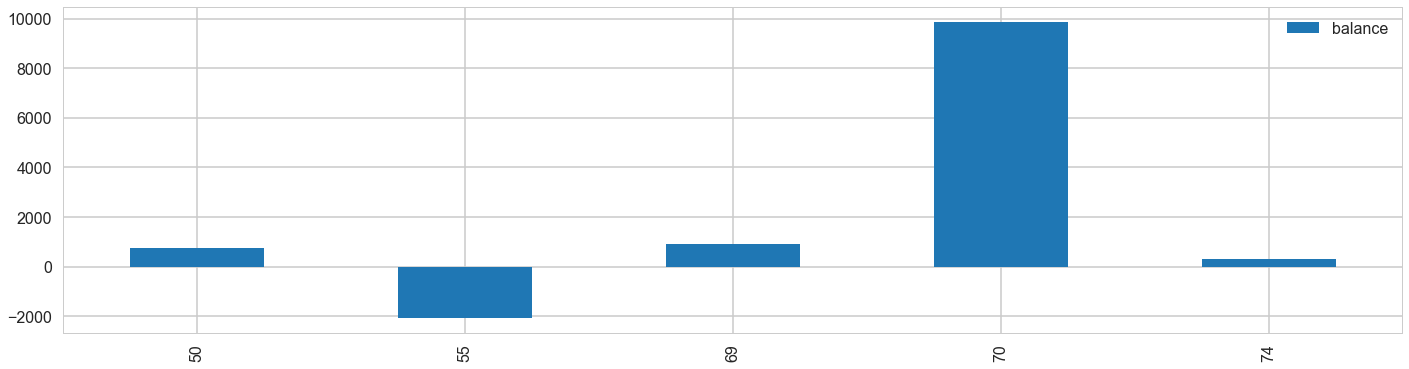

In [26]:
df = pd.DataFrame(balances)
df.fillna(0, inplace=True)
df = df.transpose()

df['balance'] = df.apply(lambda row: get_value(row), axis=1)
df = df['balance'].to_frame()

df.plot(kind='bar', figsize=(24,6))
plt.show()

In [27]:
trips.shape[0] / len(pd.unique(trips.start_date.dt.date))

869.4786169244768

# Plotting Trip Destinations and Originations for Each Station 
<p>Largest Negative Inbalance, where is everyone going?</p>

In [29]:
def plot_terminal_connections_outbound(df=None, start_term=70, prefix=''):
    
    df = df[df.start_terminal == start_term].copy()
    
    ax = df.groupby(['end_terminal']).count()['trip_id'].plot(kind='bar', figsize=(24,6), color='b', alpha=0.35)
    title = '%s Destinations from Station %s' % (prefix, start_term)
    
    ax.set_xlabel('Destination Station')
    ax.set_ylabel('Number of Trips')
    ax.set_title(title, size=TITLE_FONT_SIZE)
    file_name = '../charts/balancing/connections/outbound_%s' % title.replace(' ', '_')
    plt.savefig(file_name)
    plt.show()

def plot_terminal_connections_inbound(df=None, end_term=70, prefix=''):

    df = df[df.end_terminal == end_term].copy()
    ax = df.groupby(['start_terminal']).count()['trip_id'].plot(kind='bar', figsize=(24,6), color='b', alpha=0.35)
    title = '%s Origins to Station %s' % (prefix, end_term)
    
    ax.set_xlabel('Origin Station')
    ax.set_ylabel('Number of Trips')
    ax.set_title(title, size=TITLE_FONT_SIZE)
    file_name = '../charts/balancing/connections/inbound_%s' % title.replace(' ', '_')
    plt.savefig(file_name)
    plt.show()

In [405]:
def plot_hourly_inbound_outbound(df=None, terminal=70, suffix='', alpha=0.35):
    
    title = 'Station %s Hourly %s Traffic' % (terminal, suffix)
    title = title.strip()
    
    # count hourly trips to this terminal
    inbound = df[df.end_terminal == terminal]
    inbound_hourly = inbound.groupby(inbound.end_date.dt.hour).count()['trip_id'].to_frame()
    inbound_hourly.columns = ['inbound_hourly']
    
    outbound = df[df.start_terminal == terminal]
    outbound_hourly = outbound.groupby(outbound.start_date.dt.hour).count()['trip_id'].to_frame()
    outbound_hourly.columns = ['outbound_hourly']
    
    hourly_traffic = inbound_hourly.merge(outbound_hourly, left_index=True, right_index=True, how='outer')

    # fill in missing index
    new_index = pd.Index(range(0, 24, 1), name='ID')
    hourly_traffic = hourly_traffic.reindex(new_index)
    hourly_traffic.fillna(0, inplace=True)

    plt.subplots(figsize=(24,6))
    ax = sns.barplot(x=hourly_traffic.index, y=hourly_traffic.inbound_hourly, color='b', alpha=alpha, label='inbound')
    sns.barplot(x=hourly_traffic.index, y=hourly_traffic.outbound_hourly, ax=ax, color='r', alpha=alpha, label='outbound')
    
    plt.title(title, size=TITLE_FONT_SIZE)
    plt.legend(loc=1, frameon=True)
    ax.set_xlabel('Hour', size=LABEL_FONT_SIZE)
    ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE)
    
    file_name = '../charts/balancing/hourly/%s' % title.replace(' ', '_')
    plt.savefig(file_name)
    
    # be memory effecient, close the figure once we are done with it
    plt.close('all')

In [406]:
subscriber_trips = trips[trips.user_type == 'Subscriber'].copy()
customer_trips = trips[trips.user_type == 'Customer'].copy()

## Plot Hourly Traffic at each Station

In [407]:
for terminal in sorted(trips.start_terminal.unique()):
    plot_hourly_inbound_outbound(terminal=terminal, df=subscriber_trips, suffix='Subscribers')
    plot_hourly_inbound_outbound(terminal=terminal, df=subscriber_trips[subscriber_trips.start_date.dt.dayofweek < 5], suffix='Subscribers Weekday')
    plot_hourly_inbound_outbound(terminal=terminal, df=subscriber_trips[subscriber_trips.start_date.dt.dayofweek >= 5], suffix='Subscribers Weekend')
    plot_hourly_inbound_outbound(terminal=terminal, df=customer_trips, suffix='Customers')

# Weekly Traffic Patterns

In [419]:
def plot_weekly_inbound_outbound(df=None, terminals=[70], suffix='', title='', alpha=0.35):
    if title == '':
        terminal_titles = ' '.join([str(x) for x in terminals])
        title = 'Station %s Weekly %s Traffic' % (terminal_titles, suffix)
        title = title.replace('  ', ' ').replace("'", '')
        title = title.strip()
    else:
        title = title
        
    #--------------------------------------------------------------------------------
    #   count weekly and hourly trips at specified terminal
    #--------------------------------------------------------------------------------
#     inbound = df[df.end_terminal == terminal]
    inbound = df[df.end_terminal.isin(terminals)]
    inbound_hourly = inbound.groupby([inbound.end_date.dt.dayofweek, inbound.end_date.dt.hour]).count()['trip_id'].to_frame()
    inbound_hourly.columns = ['inbound_hourly']
    inbound_hourly.index.names = ['dayofweek', 'hour']

#     outbound = df[df.start_terminal == terminal]
    outbound = df[df.start_terminal.isin(terminals)]
    outbound_hourly = outbound.groupby([outbound.start_date.dt.dayofweek, outbound.start_date.dt.hour]).count()['trip_id'].to_frame()
    outbound_hourly.columns = ['outbound_hourly']
    outbound_hourly.index.names = ['dayofweek', 'hour']
    
    hourly_influx = inbound_hourly.merge(outbound_hourly, left_index=True, right_index=True, how='outer')
    hourly_influx.reset_index(inplace=True)
    
    hourly_influx['ID'] = (hourly_influx.dayofweek * 24) + hourly_influx.hour
    weekly_traffic = hourly_influx.copy()
    
    # fill in missing index
    new_index = pd.Index(range(0, 24*7, 1), name='ID')
    weekly_traffic = weekly_traffic.set_index('ID').reindex(new_index)
    weekly_traffic.fillna(0, inplace=True)

    
    #--------------------------------------------------------------------------------
    #   plotting
    #--------------------------------------------------------------------------------
    plt.subplots(figsize=(24,6))
    ax = sns.barplot(x=weekly_traffic.index, y=weekly_traffic.inbound_hourly, color='b', alpha=alpha, label='inbound')
    sns.barplot(x=weekly_traffic.index, y=weekly_traffic.outbound_hourly, ax=ax, color='r', alpha=alpha, label='outbound')
    
    plt.title(title, size=TITLE_FONT_SIZE)
    plt.legend(loc=1, frameon=True)
    
    ax.set_xticks([x*24+13 for x in range(0, 7, 1)])
    ax.set_xticklabels(day_labels_full)
    for vline in [x*24 for x in range(1, 7, 1)]:
        ax.axvline(x=vline, linestyle=':', color='k', alpha=0.5)
    ax.set_xlabel('Hour', size=LABEL_FONT_SIZE)
    ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE)
#     plt.show()
    file_name = '../charts/balancing/weekly/%s' % title.replace(' ', '_')
    plt.savefig(file_name)
    
    # be memory effecient, close the figure once we are done with it
    plt.close('all')
    print('Finished %s' % title)

## Plot Weekly Traffic at each Station

In [420]:
for terminal in sorted(trips.start_terminal.unique()):
    plot_weekly_inbound_outbound(terminals=[terminal], df=trips, suffix='', title='')

Finished Station 2 Weekly Traffic
Finished Station 3 Weekly Traffic
Finished Station 4 Weekly Traffic
Finished Station 5 Weekly Traffic
Finished Station 6 Weekly Traffic
Finished Station 7 Weekly Traffic
Finished Station 8 Weekly Traffic
Finished Station 9 Weekly Traffic
Finished Station 10 Weekly Traffic
Finished Station 11 Weekly Traffic
Finished Station 12 Weekly Traffic
Finished Station 13 Weekly Traffic
Finished Station 14 Weekly Traffic
Finished Station 16 Weekly Traffic
Finished Station 21 Weekly Traffic
Finished Station 22 Weekly Traffic
Finished Station 23 Weekly Traffic
Finished Station 24 Weekly Traffic
Finished Station 25 Weekly Traffic
Finished Station 26 Weekly Traffic
Finished Station 27 Weekly Traffic
Finished Station 28 Weekly Traffic
Finished Station 29 Weekly Traffic
Finished Station 30 Weekly Traffic
Finished Station 31 Weekly Traffic
Finished Station 32 Weekly Traffic
Finished Station 33 Weekly Traffic
Finished Station 34 Weekly Traffic
Finished Station 35 Weekly T

## Plot Hourly Traffic at Caltrain 'Super Station'
<p>Stations 69 and 70 are across the street from each other and the most popular stations in the program</p>
<p>Plot weekly traffic as if they were a sigle station</p>

In [421]:
plot_weekly_inbound_outbound(terminals=[69, 70], df=trips, suffix='', title='Caltrain \'Super Station\' Weekly Traffic')

Finished Caltrain 'Super Station' Weekly Traffic


In [ ]:

plot_terminal_connections_outbound(df=subscriber_trips, start_term=56, prefix='Subscriber')
plot_terminal_connections_outbound(df=customer_trips, start_term=56, prefix='Customer')

In [ ]:
plot_terminal_connections_inbound(df=subscriber_trips, end_term=56, prefix='Subscriber')

# MOST POPULAR INBOUND ROUTES FOR EACH STATION

In [ ]:
for eid in sorted(subscriber_trips.end_terminal.unique()):
    
    plot_terminal_connections_inbound(df=subscriber_trips, end_term=eid, prefix='Subscriber')

# MOST POPULAR OUTBOUND ROUTES FOR EACH STATION

In [ ]:
for sid in sorted(subscriber_trips.start_terminal.unique()):
    
    plot_terminal_connections_outbound(df=subscriber_trips, start_term=sid, prefix='Subscriber')

## Status Data

In [ ]:
print('[%s] Loading Status Data...' % datetime.datetime.now().time())

status_df = pd.DataFrame()
data_file = '../clean_data/bayareabikeshare/status_data_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['time']):
    
    # prune chunks
    chunk = chunk[chunk.station_id.isin(pop_commuter_stations)]
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

status_df = pd.concat(chunks)
# trips_df.user_type = trips_df.user_type.astype('category')

status_df.drop_duplicates(inplace=True)
status_df.dock_count = status_df.dock_count.astype('int')
status_df.zip_code   = status_df.zip_code.astype('int')

status_df.reset_index(inplace=True, drop=True)

print('[%s] Complete!' % datetime.datetime.now().time())

In [ ]:
status_df.info()

In [ ]:
status_df.head(3)

In [ ]:
s70_status = status_df[status_df.station_id == 70].copy()

s70_status.sort_values('time', inplace=True)
s70_status.reset_index(inplace=True, drop=True)
s70_status.set_index('time', inplace=True)


s70_status['bike_avail_diff'] = s70_status.bikes_available - s70_status.bikes_available.shift(1)
s70_status.fillna(0, inplace=True)

s70_status.head(20)

In [ ]:
ax = s70_status.groupby([s70_status.index.dayofyear]).max().bike_avail_diff.plot(figsize=(24,6), color='b', label='Max Difference')
s70_status.groupby([s70_status.index.dayofyear]).min().bike_avail_diff.plot(ax=ax, color='r', label='Min Difference')
s70_status.groupby([s70_status.index.dayofyear]).mean().bike_avail_diff.plot(ax=ax, color='g', label='Mean Difference')
s70_status.groupby([s70_status.index.dayofyear]).median().bike_avail_diff.plot(ax=ax, color='c', label='Median Difference')

ax.set_title('Change in Reported Number of Available Bikes')
ax.legend(loc=2, frameon=True)
plt.show()

In [ ]:
ax = s70_status.groupby([s70_status.index.date]).max().bike_avail_diff.plot(figsize=(24,6), color='b', label='Max Difference')
s70_status.groupby([s70_status.index.date]).min().bike_avail_diff.plot(ax=ax, color='r', label='Min Difference')

ax.set_title('Change in Reported Number of Available Bikes')
ax.legend(loc=2, frameon=True)
plt.show()

In [ ]:
s70_balance = station_balance[station_balance.terminal == 70].copy()
s70_balance.head(3)

In [ ]:
s70_status.head(3)

In [ ]:
s70_status_diff = s70_status[['bike_avail_diff']].copy()
s70_status_diff.reset_index(inplace=True)
s70_status_diff.head()

In [ ]:
s70_trip_diff = s70_balance[['time', 'balance']].copy()
s70_trip_diff.reset_index(inplace=True, drop=True)
s70_trip_diff.fillna(0, inplace=True)
s70_trip_diff.head()

In [ ]:
s70_merge = s70_status_diff.merge(s70_trip_diff, left_on='time', right_on='time', how='left')
s70_merge.fillna(0, inplace=True)

s70_merge.columns = ['time', 'status_diff', 'trip_diff']
s70_merge.drop_duplicates(inplace=True)
s70_merge.set_index('time', inplace=True)

s70_merge['ALT'] = s70_merge.status_diff - s70_merge.trip_diff.shift(1)

s70_merge.head(30)

In [ ]:
s70_merge.groupby([s70_merge.index.dayofweek, s70_merge.index.hour]).sum().ALT.plot(kind='bar', figsize=(36,6))
plt.title('Number of Trips Arriving - Reported Increase in Available Bikes')
plt.show()